In [2]:
# Imports
from matplotlib.collections import LineCollection
from matplotlib import cm
import math

import pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from copy import deepcopy
#import plotly.graph_objects as go
from scipy.optimize import curve_fit
from dataclasses import make_dataclass

import sys
module_path = 'maze_utils' 
if module_path not in sys.path:
    sys.path.append(module_path)

from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [7]:
# Define and populate the maze structure ma, used as an argument for many functions
ma=NewMaze(6)

# non-valid maze parts
re=[[-0.5,0.5,1,1],[-0.5,4.5,1,1],[-0.5,8.5,1,1],[-0.5,12.5,1,1],
       [2.5,13.5,1,1],[6.5,13.5,1,1],[10.5,13.5,1,1],
       [13.5,12.5,1,1],[13.5,8.5,1,1],[13.5,4.5,1,1],[13.5,0.5,1,1],
       [10.5,-0.5,1,1],[6.5,-0.5,1,1],[2.5,-0.5,1,1],
       [6.5,1.5,1,1],[6.5,11.5,1,1],[10.5,5.5,1,1],[10.5,7.5,1,1],
       [5.5,4.5,1,1],[5.5,8.5,1,1],[7.5,4.5,1,1],[7.5,8.5,1,1],[2.5,5.5,1,1],[2.5,7.5,1,1],
       [-0.5,2.5,3,1],[-0.5,10.5,3,1],[11.5,10.5,3,1],[11.5,2.5,3,1],[5.5,0.5,3,1],[5.5,12.5,3,1],
       [7.5,6.5,7,1]]

In [8]:
# get a path of a bout (list of coordinates)
def get_path_552(nickname,b):
    tf=LoadTraj(nickname+'-tf')
    x=-0.5+15*tf.ke[b][:,0]
    y=-0.5+15*tf.ke[b][:,1]
    t=np.linspace(0,1,x.shape[0]) # time variable
    points = np.array([list(x),list(y)]).transpose().tolist()
    points = list(filter(lambda x: (not math.isnan(x[0])) or (not math.isnan(x[1])), points))
    points=np.round(points)
    points = np.array(points,dtype=int)
    points = [x for x in points if tuple(x) in ma.ce.keys()]

    points = [i for (i,j) in zip(points[1:], points) if len(ConnectPath(ma.ce[tuple(j)], ma.ce[tuple(i)], ma))<6]

    points_copy = points.copy()
    offset = 0
    for i, (x,y) in enumerate(zip(points[1:], points)):
        path = ConnectPath(ma.ce[tuple(y)], ma.ce[tuple(x)], ma)
        if len(path)>2:
            coords = []
            for idx in path[1:-1]:
                coords.append((ma.xc[idx], ma.yc[idx]))
            points_copy[i+1+offset:i+1+offset] = coords
            offset += len(coords)

    return points_copy, t

In [9]:
# plot a path (list of coordinates)
def plot_path_552(points, t, ax):
    points = np.array(points).reshape(-1,1,2)

    segs=np.concatenate([points[:-1],points[1:]],axis=1) # array of segments
    lc=LineCollection(segs,cmap=plt.get_cmap('viridis'),linewidths=1.5) # collect segments
    lc.set_array(t) # color the segments by the time variable
    plot(ma.wa[:,0],ma.wa[:,1],fmts=['k-'],equal=True,linewidth=1,yflip=True,
              xhide=True,yhide=True,axes=ax) # Draw the maze outline    
    for r in re:
        rect=patches.Rectangle((r[0],r[1]),r[2],r[3],linewidth=1,edgecolor='lightgray',facecolor='lightgray')
        ax.add_patch(rect)
    ax.axis('off'); # turn off the axes
    ax.add_collection(lc); # add the collection to the plot

In [ ]:
# Order:
#  B1 B2 B3 B4 C1 
#  C3 C6 C7 C8 C9 
#  B5 B6 B7 D3 D4 
#  D5 D7 D8 D9

In [68]:
# get first proper bouts (beyond the first junction) of all 19 animals
with open('outdata/HomeRuns', 'rb') as f:
    Names,HR=pickle.load(f) # bout, starting node, node distance, absolute frame   
sb=[hr[hr[:,2]>1,0][0] for hr in HR] # bout of first home run if past first intersection
paths, time = [], []
for i,nickname in enumerate(Names):
    print(nickname)
    path, time_var = get_path_552(nickname,sb[i])
    paths.append(path)
    time.append(time_var)
print(sb)

B1
B2
B3
B4
C1
C3
C6
C7
C8
C9
B5
B6
B7
D3
D4
D5
D7
D8
D9
[13, 1, 5, 2, 2, 1, 1, 0, 1, 1, 1, 2, 2, 1, 4, 1, 1, 1, 2]


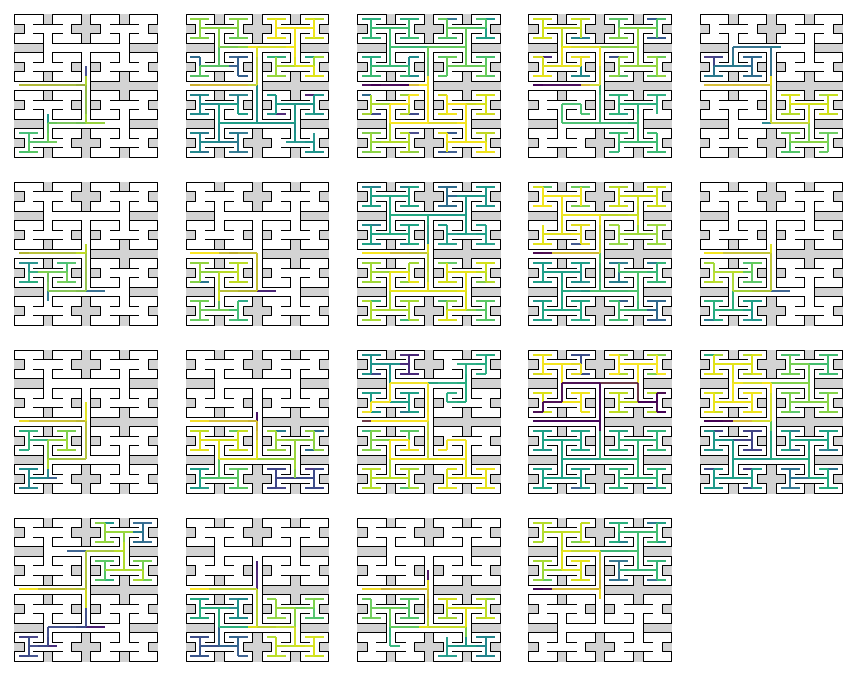

In [11]:
# plot first proper bouts (beyond the first junction) of all 19 animals
fig,ax=plt.subplots(4,5,figsize=(12,10))
for i in range(len(paths)):
    plot_path_552(paths[i], time[i], ax[i//5,i%5])

lastax=ax[-1,-1] # deal with the last panel
plot([0],[0],fmts=['w.'],equal=True,yflip=True,
          xhide=True,yhide=True,axes=lastax) # Draw nothing, helps for some reason 
lastax.axis('off')
plt.show()

### @Naomi, below is an example for one mouse, but this is how to remove consecutive duplicate coordinates

i.e., if path is [(0,7), (0,7), (0,7), (0,7), (0,7), (1,7), (1,7) (1,7) (1,7), (2,7), (2,7), (2,7), (1,7), (0,7)],
        then the code below will outupt [(0,7), (1,7), (2,7), (1,7), (0,7)],
        which is what we should use for the metrics

In [72]:
path, time_var = get_path_552('B2',sb[1])
path_2 = [v for i, v in enumerate(path) if i == 0 or (path[i] != path[i-1]).any()]
print(path_2)

AttributeError: 'bool' object has no attribute 'any'

In [66]:
#these are just all the ones in outdata
mouse_names= ['B1','B2','B3', 'B4', 'B5', 'B6', 'B7', 'C1', 'C3', 'C6','C7', 'C8','C9','D3','D4','D5','D6','D7','D8','D9']

#dictionaries for all mice
dir_dic={}

for mouse in mouse_names:
    #path, time_var = get_path_552('B1',sb[0])
    print('1')
    path, time_var = get_path_552(mouse,sb[2]) # not sure if this is right lol idk what sb[0] is
    print('2')
    path_2 = [v for i, v in enumerate(path) if i == 0 or (path[i] != path[i-1]).any()]
    print('3')
    #convert coordinates to indices
    index_list = [ma.ce[tuple(path)] for path in path_2] 

    # convert indicies to nodes
    # maze.ru is a list of lists, where the inner lists are the indices of the coordinates that are associated to each node
    node_list= []
    for index in index_list:
        for i, node_idx_list in enumerate (ma.ru):
            if index in node_idx_list:
                node_list.append(i)

    #convert nodes to steps
    step_list= []
    for start, end in zip(node_list, node_list[1:]):
        step_type= ma.st[start,end]
        step_list.append(step_type)

    # convert steps to directions (left/right/back/straight)
    dir_list=[]
    for start, end in zip(step_list, step_list[1:]):
        # in left = 0; in right = 1; out left = 2; out right = 3; illegal = -1
        # out right, out right: left turn
        if start==3 & end == 3:
            dir_list.append('left')
        # out left, out left: right turn
        if start==2 & end == 2:
            dir_list.append('right')
        # out right, out left: left turn
        if start==3 & end == 2:
            dir_list.append('left')
        # out left, out right: right 
        if start==2 & end == 3:
            dir_list.append('right')

        # in right, out right: backwards
        if start==1 & end == 3:
            dir_list.append('back')
        # in left, out left: backwards
        if start==0 & end == 2:
            dir_list.append('back')
        # out right, in right: backwards
        if start==3 & end == 1:
            dir_list.append('back')
        # out left, in left: backwards
        if start==2 & end == 0:
            dir_list.append('back')

        # in right, in right: right
        if start==1 & end == 1:
            dir_list.append('right')
        # in left, in left: left
        if start==0 & end == 0:
            dir_list.append('left')
        # in right, in left: left
        if start==1 & end == 0:
            dir_list.append('left')
        # in left, in right: right
        if start==0 & end == 1:
            dir_list.append('right')

        # in right, out left: not possible
        if start==1 & end == 2:
            dir_list.append('illegal')
        # out left, in right: straight
        if start==2 & end == 1:
            dir_list.append('straight')
        # in left, out right: not possible
        if start==0 & end == 3:
            dir_list.append('illegal')
        # out right, in left: straight
        if start==3 & end == 0:
            dir_list.append('straight')
    dir_dic[mouse]= dir_list

1
2


AttributeError: 'bool' object has no attribute 'any'

In [53]:
dir_dic

{'B1': ['left',
  'left',
  'left',
  'left',
  'left',
  'left',
  'right',
  'left',
  'left',
  'left',
  'right',
  'right',
  'left',
  'left',
  'right',
  'right',
  'right',
  'right',
  'right',
  'left',
  'right',
  'right',
  'left',
  'left',
  'left',
  'left',
  'right',
  'right',
  'right',
  'right',
  'left',
  'left',
  'right',
  'back',
  'left',
  'right',
  'left',
  'left',
  'right',
  'left',
  'left',
  'left',
  'right',
  'left',
  'back',
  'left',
  'right',
  'left',
  'left',
  'left',
  'left',
  'right',
  'left',
  'back',
  'left',
  'left',
  'straight',
  'left',
  'left',
  'left',
  'left',
  'right',
  'left',
  'right',
  'left',
  'left',
  'left',
  'right',
  'right',
  'left',
  'left',
  'right',
  'left',
  'left',
  'right']}

In [ ]:
# get % of actions/movements (probably want per mouse and also overall)
# look at dir_dic
